In [35]:
import pandas as pd
import locale
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

from pandas.tseries.offsets import MonthEnd

locale.setlocale(locale.LC_ALL, "sl_SI.utf8")

'sl_SI.utf8'

In [36]:
regije_filter = {
    "SO2": [
        "Koroška",
        "Osrednjeslovenska",
        "Posavska",
        "Savinjska",
        "Zasavska",
    ],
    "PM10":[
        "Goriška",
        "Osrednjeslovenska",
        "Podravska",
        "Pomurska",
        "Posavska",
        "Savinjska",
        "Zasavska",
    ],
    "NO2": [
        "Zasavska",
        "Savinjska",
        "Pomurska",
        "Podravska",
        "Osrednjeslovenska",
        "Goriška"
    ]
}


df = pd.read_csv("podatki/wide_df.csv").drop(columns="Postaja")
df.insert(
    loc=1,
    column="Datum",
    value=pd.to_datetime(
        df["Leto"].astype(str) + "-" + df["Mesec"].astype(str), format="%Y-%b"
    )
    + MonthEnd(0),
)
df = df.drop(columns=["Leto", "Mesec"])

In [37]:
so2_agg = df[df["Regija"].isin(regije_filter["SO2"])]
so2_agg = so2_agg.groupby(["Regija", "Datum"])["SO2"].mean().reset_index()
so2_agg.sort_values(by=["Datum", "Regija"], inplace=True)

so2_agg = so2_agg.pivot(index="Datum", columns="Regija", values="SO2")

In [38]:
descriptive_stats = so2_agg.describe()

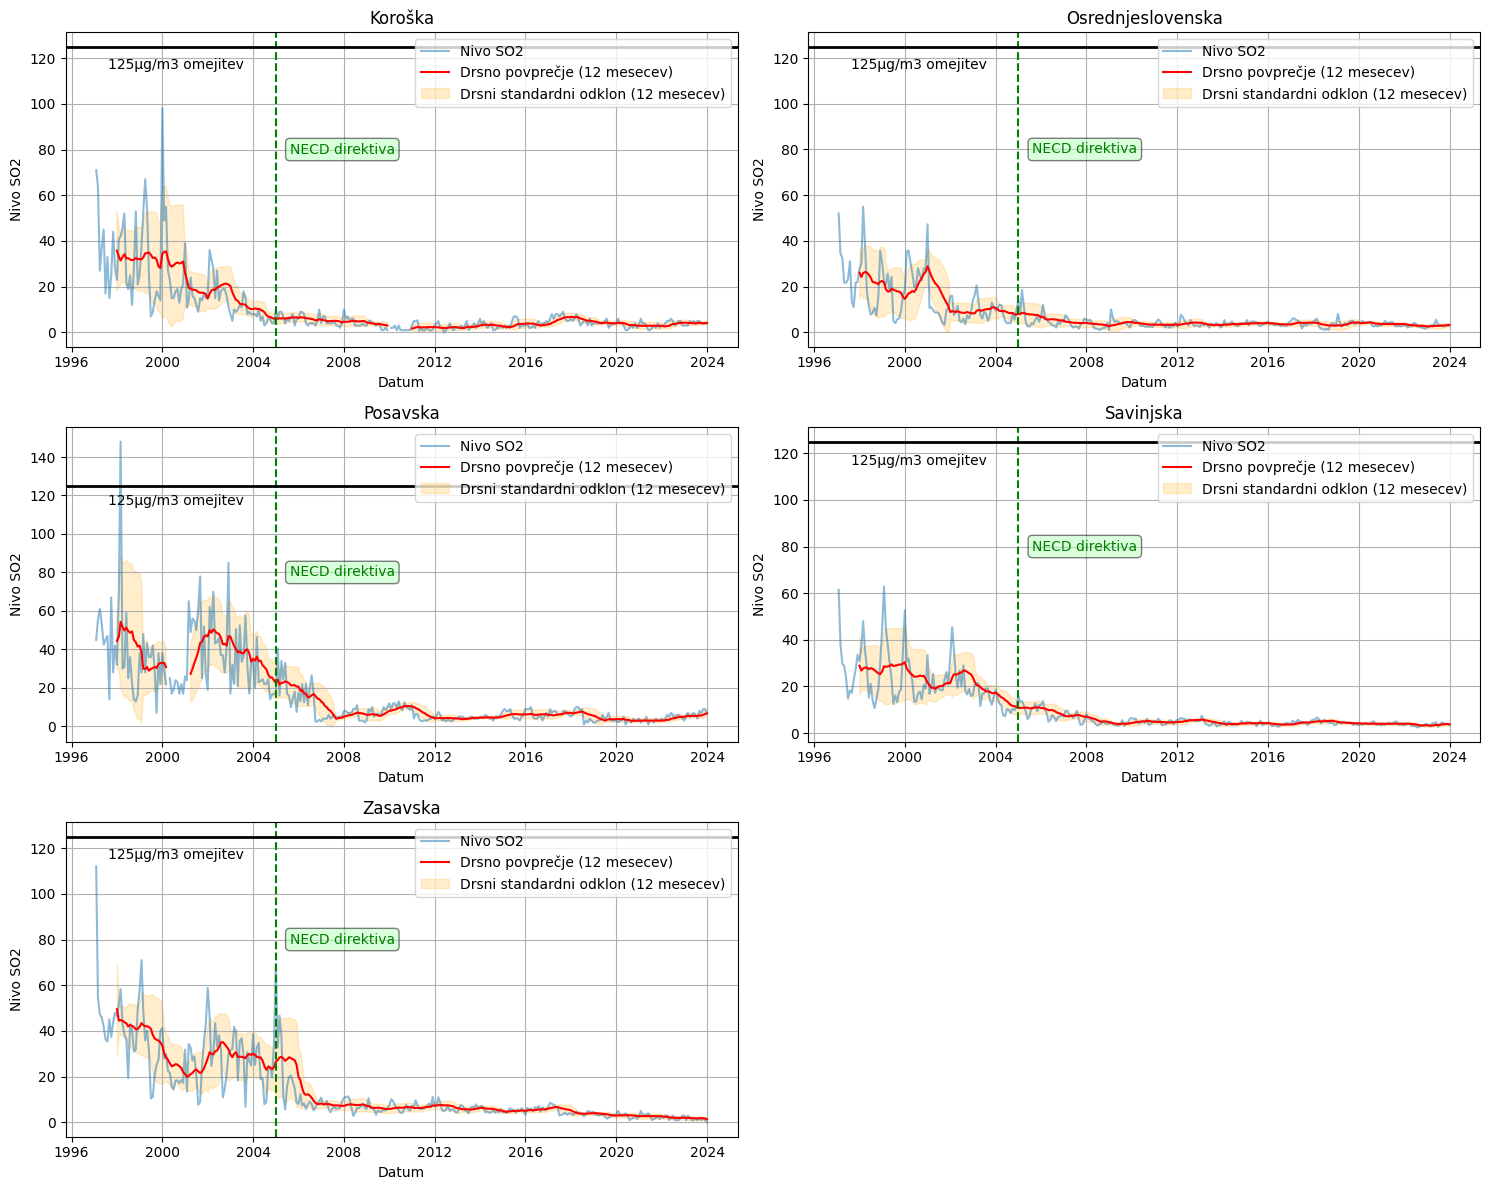

In [39]:
window_size = 12

rolling_mean = so2_agg.rolling(window=window_size).mean()
rolling_std = so2_agg.rolling(window=window_size).std()


num_regions = so2_agg.shape[1]

num_cols = 2  # Adjust as needed for your screen/paper size
num_rows = (num_regions + num_cols - 1) // num_cols

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(15, 4 * num_rows)
)  # Adjusted subplot creation

# Flatten axes for easy indexing
axes = axes.flatten()  # crucial if using subplots
for i, region in enumerate(so2_agg.columns):
    ax = axes[i]  # Get the appropriate subplot axis

    ax.plot(
        so2_agg.index, so2_agg[region], label="Nivo SO2", alpha=0.5
    )  # Added original level
    ax.plot(
        so2_agg.index,
        rolling_mean[region],
        label=f"Drsno povprečje ({window_size} mesecev)",
        color="red",
    )

    ax.fill_between(
        so2_agg.index,
        rolling_mean[region] - rolling_std[region],
        rolling_mean[region] + rolling_std[region],
        color="orange",
        alpha=0.2,
        label=f"Drsni standardni odklon ({window_size} mesecev)",
    )

    ax.set_xlabel("Datum")
    ax.set_ylabel("Nivo SO2")
    ax.set_title(f"{region}")
    ax.legend(loc="upper right")
    ax.grid(True)

    # Add vertical line and annotation for NECD Directive
    necd_date = pd.to_datetime("2005-01-01")
    ax.axvline(necd_date, color="green", linestyle="--", label="NECD direktiva")
    ax.annotate(
        "NECD direktiva",
        xy=(mdates.date2num(necd_date), 80),  # Position annotation near the top
        xytext=(10, 0),
        textcoords="offset points",  # Offset from the xy point
        bbox=dict(boxstyle="round,pad=0.3", fc="#B6FFBB", alpha=0.5),  # Box properties
        ha="left",
        va="center",
        color="green",
    )

    ax.axhline(125, color="black", linewidth=2)
    ax.annotate(
        "125µg/m3 omejitev",
        xy=(pd.to_datetime("1997-01-01"), 115),
        xytext=(10, 3),
        textcoords="offset points",
        ha="left",
        va="center",
        color="black",
    )


if num_regions < len(axes):
    for i in range(num_regions, len(axes)):
        fig.delaxes(axes[i])


plt.tight_layout()
plt.savefig("grafi/trend_gibanja_SO2_regije.png")
plt.show()


In [40]:
so2_presezki = pd.read_csv("podatki/df_regije/presezki/SO2.csv")

so2_presezki = so2_presezki.groupby(["Regija"])[
    ["SO2 - Urnih presežkov", "SO2 - Dnevnih presežkov"]
].sum().reset_index()

so2_presezki.sort_values(by=so2_presezki.columns[1:].to_list(),ascending=False,inplace=True,ignore_index=True)
so2_presezki.loc[4] = ["Osrednjeslovenska", 0,0]

so2_presezki.set_index('Regija',inplace=True)

so2_presezki


,SO2 - Urnih presežkov,SO2 - Dnevnih presežkov
Regija,,
Zasavska,521,73
Savinjska,175,6
Posavska,116,21
Koroška,4,0
Osrednjeslovenska,0,0


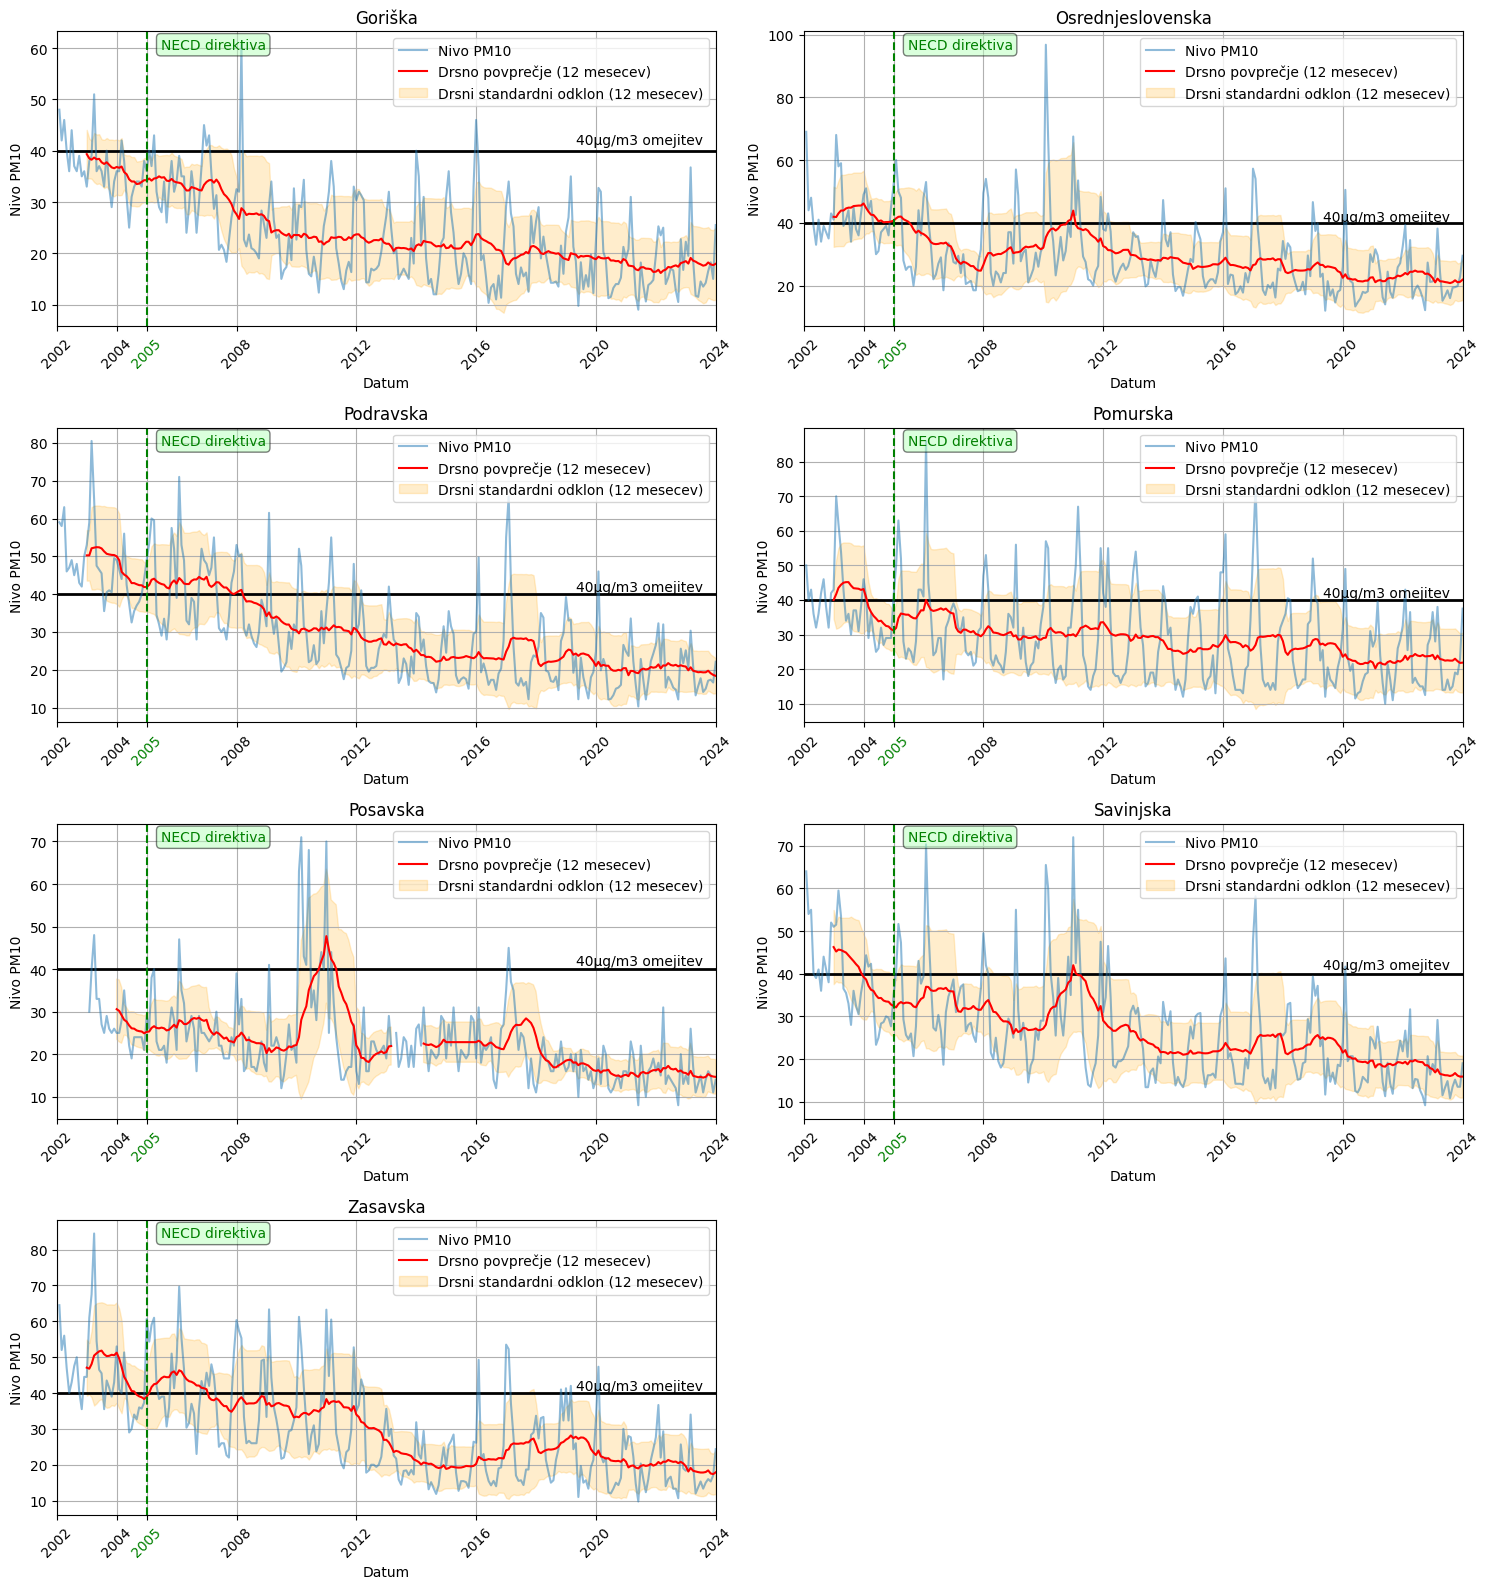

In [ ]:
pm10_agg = df[df["Regija"].isin(regije_filter["PM10"])]
pm10_agg = pm10_agg.groupby(["Regija", "Datum"])["PM10"].mean().reset_index()
pm10_agg.sort_values(by=["Datum", "Regija"], inplace=True)
pm10_agg = pm10_agg.pivot(index="Datum", columns="Regija", values="PM10")
pm10_agg = pm10_agg.loc[pm10_agg.index >= "2002-01-01", :]

rolling_mean = pm10_agg.rolling(window=window_size).mean()
rolling_std = pm10_agg.rolling(window=window_size).std()

num_regions = pm10_agg.shape[1]

num_cols = 2
num_rows = (num_regions + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
axes = axes.flatten()

for i, region in enumerate(pm10_agg.columns):
    ax = axes[i]  # Get the appropriate subplot axis

    ax.axhline(40, color="black", linewidth=2)
    ax.annotate(
        "40µg/m3 omejitev",
        xy=(pd.to_datetime("2021-01-01"), 42),
        xytext=(10, 0),
        textcoords="offset points",
        ha="center",
        va="center",
        color="black",
    )

    ax.plot(
        pm10_agg.index, pm10_agg[region], label="Nivo PM10", alpha=0.5
    )  # Added original level
    ax.plot(
        pm10_agg.index,
        rolling_mean[region],
        label=f"Drsno povprečje ({window_size} mesecev)",
        color="red",
    )

    ax.fill_between(
        pm10_agg.index,
        rolling_mean[region] - rolling_std[region],
        rolling_mean[region] + rolling_std[region],
        color="orange",
        alpha=0.2,
        label=f"Drsni standardni odklon ({window_size} mesecev)",
    )

    ax.set_xlabel("Datum")
    ax.set_ylabel("Nivo PM10")
    ax.set_title(f"{region}")
    ax.legend(loc="upper right")
    ax.grid(True)

    # Dodatni ticki
    necd_tick = mdates.date2num(pd.to_datetime("2005"))
    s_tick = mdates.date2num(pd.to_datetime("2002"))
    ax.set_xticks(sorted(list(ax.get_xticks()) + [necd_tick,s_tick]))

    ax.get_xticklabels()[3].set_color('green')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x',rotation=45)
    ax.set_xlim([pd.to_datetime('2002'),pd.to_datetime('2024')])
    


     

    # Add vertical line and annotation for NECD Directive
    necd_date = pd.to_datetime("2005-01-01")
    ax.axvline(necd_date, color="green", linestyle="--", label="NECD direktiva")
    ax.annotate(
        "NECD direktiva",
        xy=(mdates.date2num(necd_date), pm10_agg[region].max()),  # Position annotation near the top
        xytext=(10, 0),
        textcoords="offset points",  # Offset from the xy point
        bbox=dict(boxstyle="round,pad=0.3", fc="#B6FFBB", alpha=0.5),  # Box properties
        ha="left",
        va="center",
        color="green",
    )

    


if num_regions < len(axes):
    for i in range(num_regions, len(axes)):
        fig.delaxes(axes[i])

exit
plt.tight_layout()
plt.savefig("grafi/trend_gibanja_PM10_regije.png")
plt.show()


In [42]:
pm10_presezki = pd.read_csv("podatki/df_regije/presezki/PM10.csv")

pm10_presezki = pm10_presezki.groupby(['Regija'])['PM10 - Dnevnih presežkov'].sum().sort_values(ascending=False)

pm10_presezki


Regija
Zasavska                 2563.0
Osrednjeslovenska        2307.0
Podravska                1848.0
Savinjska                1819.0
Pomurska                  889.0
Goriška                   817.0
Jugovzhodna Slovenija     445.0
Obalno-kraška             284.0
Posavska                  278.0
Gorenjska                 277.0
Koroška                   252.0
Notranjsko-kraška           6.0
Name: PM10 - Dnevnih presežkov, dtype: float64

In [59]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

no2_agg = df[df["Regija"].isin(regije_filter["NO2"])]
no2_agg = no2_agg.groupby(["Regija", "Datum"])["NO2"].mean().reset_index()
no2_agg = no2_agg.pivot(index="Datum", columns="Regija", values="NO2")
no2_agg = no2_agg.loc[no2_agg.index >= "2002-01-01", :]

incomplete_cols = no2_agg.columns[
    no2_agg.isna().any()
].tolist()  # columns with missing values
complete_cols = no2_agg.columns.difference(
    incomplete_cols
).tolist()  # columns without missing values

# 2. Iterate through each incomplete column and build a model
for col in incomplete_cols:
    # Create separate dataframes for training and prediction
    df_train = no2_agg[no2_agg[col].notna()]
    df_predict = no2_agg[no2_agg[col].isna()]

    # Prepare data for the model

    temp_incomplete_cols = incomplete_cols.copy()
    temp_incomplete_cols.remove(col)
    X_train = df_train[complete_cols + temp_incomplete_cols]
    y_train = df_train[col]
    X_predict = df_predict[complete_cols + temp_incomplete_cols]

    # Handle missing values in features *within the training set*. Important.
    imputer = SimpleImputer(strategy="mean")  # or 'median', 'most_frequent', 'constant'
    X_train = imputer.fit_transform(X_train)
    X_predict = imputer.transform(X_predict)

    # Model Training:  Random Forest Regressor is often good.
    model = RandomForestRegressor(
        n_estimators=100, random_state=42
    )  # Adjust hyperparameters as needed
    model.fit(X_train, y_train)

    # Make predictions
    predicted_values = model.predict(X_predict)

    # Fill in the missing values in the original dataframe
    no2_agg.loc[no2_agg[col].isna(), col] = predicted_values



2002-01-31 00:00:00 2023-12-31 00:00:00


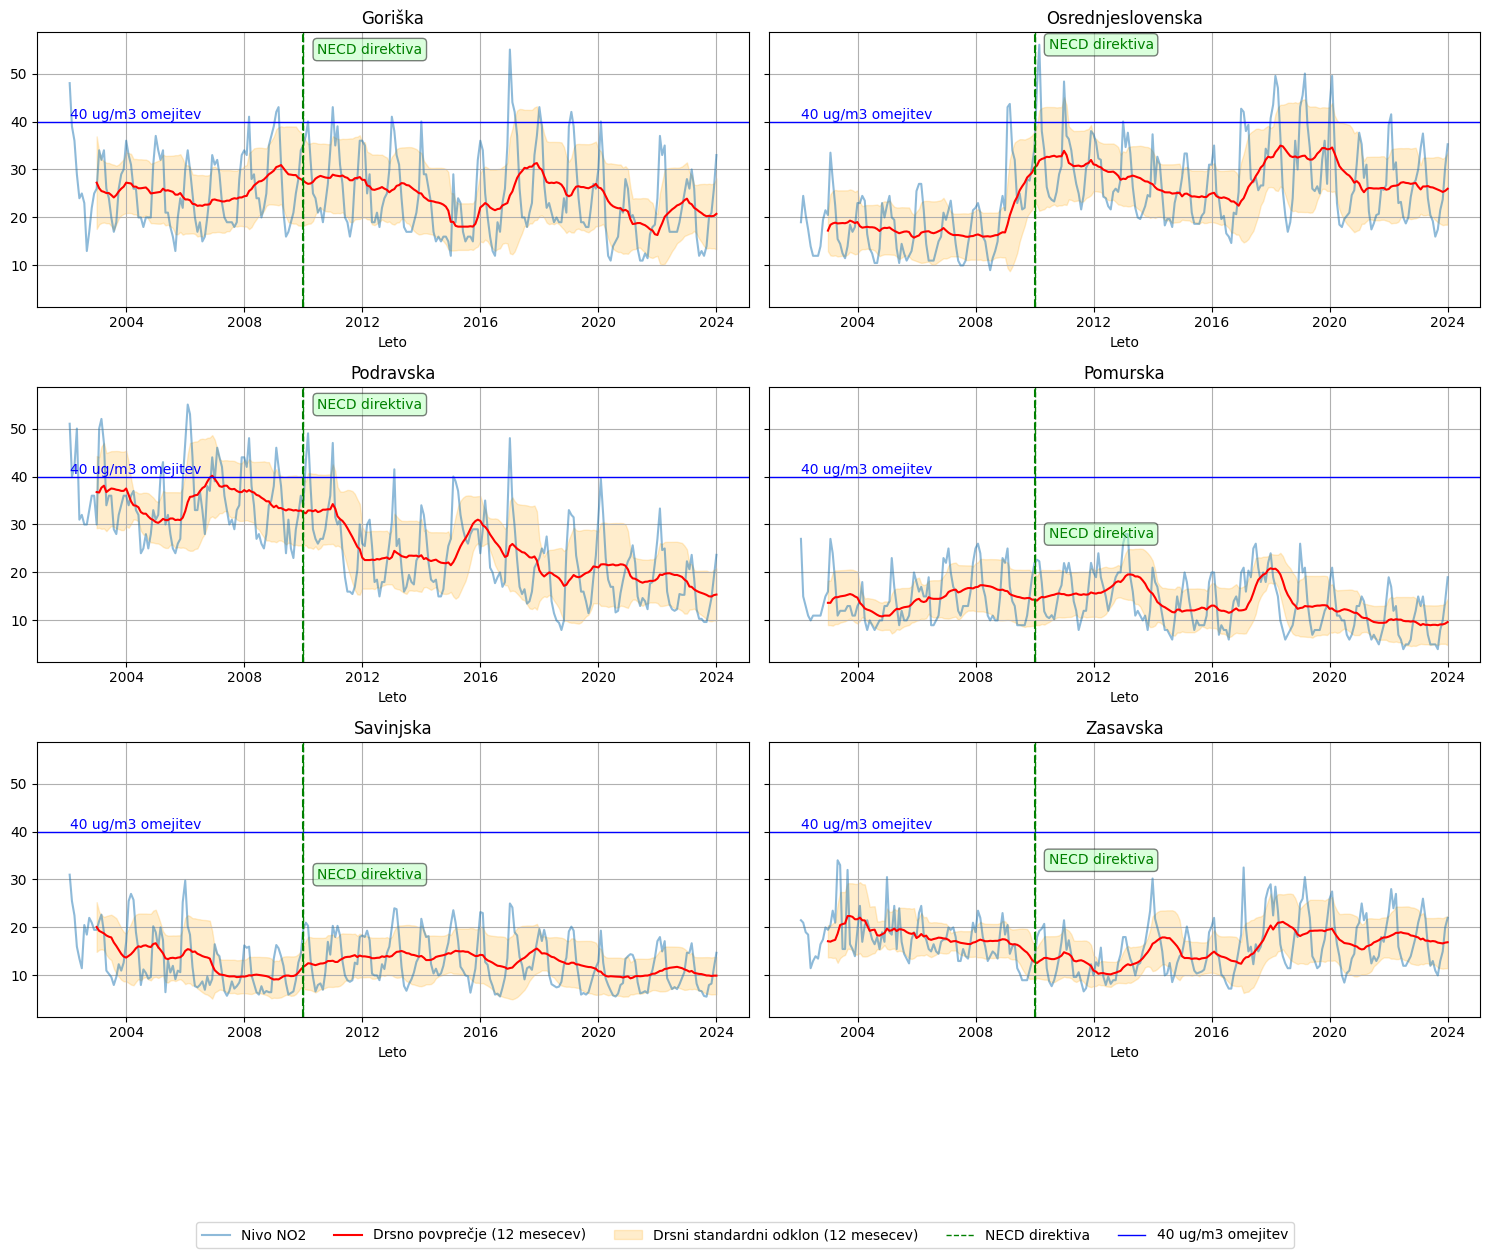

In [ ]:
SNOV = "NO2"
window_size = 12  # Example. Replace with the value you used previously.

rolling_mean = no2_agg.rolling(window=window_size).mean()
rolling_std = no2_agg.rolling(window=window_size).std()

num_regions = no2_agg.shape[1]
num_cols = 2
num_rows = (num_regions + num_cols - 1) // num_cols

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(15, 4 * num_rows), sharey=True
)  # Share x and y axes
axes = axes.flatten()

# Common labels for the first plot only (for shared legend)
labels = [
    f"Nivo {SNOV}",
    f"Drsno povprečje ({window_size} mesecev)",
    f"Drsni standardni odklon ({window_size} mesecev)",
    "NECD direktiva",
    "40 ug/m3 omejitev",
]

for i, region in enumerate(no2_agg.columns):
    ax = axes[i]

    ax.plot(no2_agg.index, no2_agg[region], label=labels[0], alpha=0.5)
    ax.plot(no2_agg.index, rolling_mean[region], label=labels[1], color="red")
    ax.fill_between(
        no2_agg.index,
        rolling_mean[region] - rolling_std[region],
        rolling_mean[region] + rolling_std[region],
        color="orange",
        alpha=0.2,
        label=labels[2],
    )

    ax.axvline(
        pd.to_datetime("2010-01-01"),
        color="green",
        linestyle="--",
        linewidth=1,
        label=labels[3] if i == 0 else None,
    )

    ax.axhline(
        y=40,
        color="blue",
        linestyle="-",
        linewidth=1,
        label=labels[4] if i == 0 else None,
    )
    ax.text(
        no2_agg.index[0],
        40,
        "40 ug/m3 omejitev",
        color="blue",
        verticalalignment="bottom",
    )

    ax.set_xlabel("Leto")  # Remove ylabel here (shared)
    ax.set_title(f"{region}")
    ax.grid(True)

    necd_date = pd.to_datetime("2010-01-01")
    ax.axvline(necd_date, color="green", linestyle="--", label="NECD direktiva")
    ax.annotate(
        "NECD direktiva",
        xy=(
            mdates.date2num(necd_date),
            no2_agg[region].max(),
        ),  # Position annotation near the top
        xytext=(10, 0),
        textcoords="offset points",  # Offset from the xy point
        bbox=dict(boxstyle="round,pad=0.3", fc="#B6FFBB", alpha=0.5),  # Box properties
        ha="left",
        va="center",
        color="green",
    )

    necd_tick = mdates.date2num(necd_date)
    s_tick = mdates.date2num(pd.to_datetime("2002"))
    ax.set_xticks(sorted(list(ax.get_xticks()) + [necd_tick,s_tick]))
    ax.get_xticklabels()[3].set_color('green')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x',rotation=45)
    ax.set_xlim([pd.to_datetime('2002'),pd.to_datetime('2024')])
    
all_handles = []
all_labels = []

for ax in axes[:num_regions]:  # Only use the real subplots, skip the empty ones
    handles, labels = ax.get_legend_handles_labels()
    for h, l in zip(handles, labels):
        if l not in all_labels:  # Avoid duplicates
            all_handles.append(h)
            all_labels.append(l)

# Add combined legend below
fig.legend(
    all_handles,
    all_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=len(all_labels),
)

fig.tight_layout(rect=[0, 0.1, 1, 1])  # Make space for the single legend
plt.show()